In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import pickle
torch.set_num_threads(1)
import time

def gen_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[2., 1.], linspace=1000, noise=0.03, seed=7):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]
    np.random.seed(seed)
    states *= np.random.normal(1, noise, states.shape)
    return np.log(states)

    
plt.rcParams['savefig.dpi'] = 200 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
torch.set_num_threads(1)
n_batch = 100
batch_size = 12
np.random.seed(11)
cp_val = np.random.binomial(1, 0.05, n_batch)
cp_series = np.zeros(0)
for i in range(n_batch):
    if cp_val[i] == 0:
        cp_series = np.concatenate((cp_series, np.zeros(batch_size)), axis=None)
    else:
        np.random.seed(i)
        new_series = np.random.multinomial(1, [1/batch_size] * batch_size)
        cp_series = np.concatenate((cp_series, new_series), axis=None)
        
# construct gamma series
print(cp_series.shape)
discretization=1
obs_per_day=12
days = 8
total_days = int(days + n_batch * batch_size / obs_per_day)
print(total_days)
alpha0 = 0.6
beta0 = 0.75 
delta0 = 1. 
# 
MAGI_iter = 15001
gamma_ls = [0.6, 1.0]
gamma = 0.6 * np.ones(12000 * days)
label = 0
for i in range(n_batch * batch_size):
    if cp_series[i]:
        label = 1-label
    val_tmp = gamma_ls[label]
    gamma = np.concatenate((gamma, val_tmp * np.ones(1000)))  

print(gamma.shape)
yobs_np = gen_data(alpha0, beta0, delta0, gamma, total_days, obs_per_day)
cp_series

(1200,)
108
(1296000,)


array([0., 0., 0., ..., 0., 0., 0.])

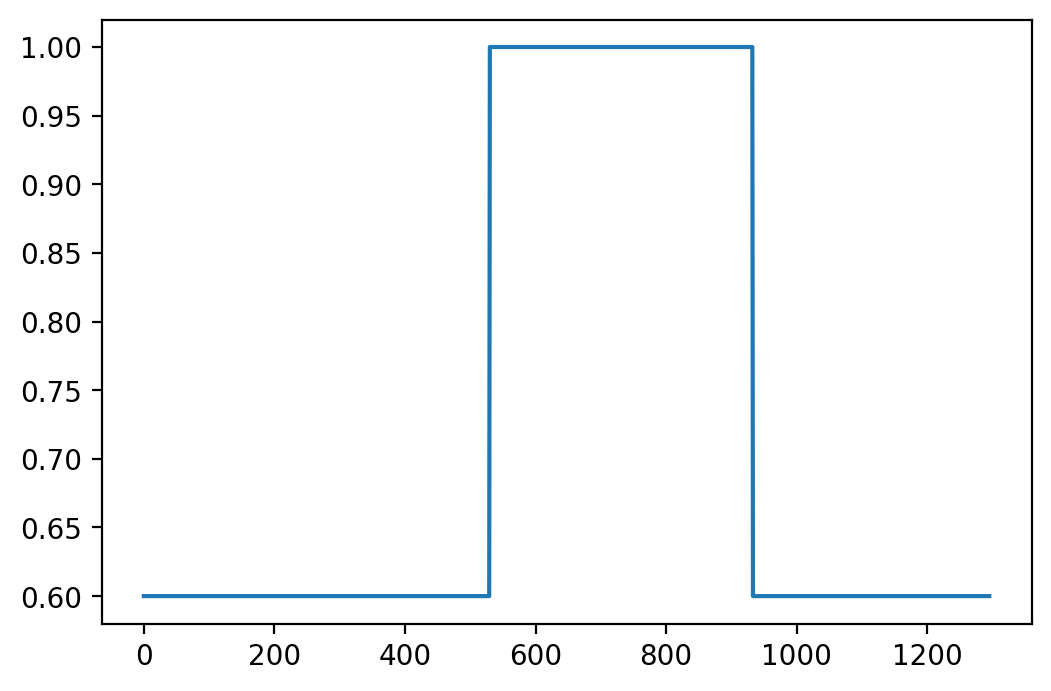

In [2]:
plt.plot(gamma[::1000])

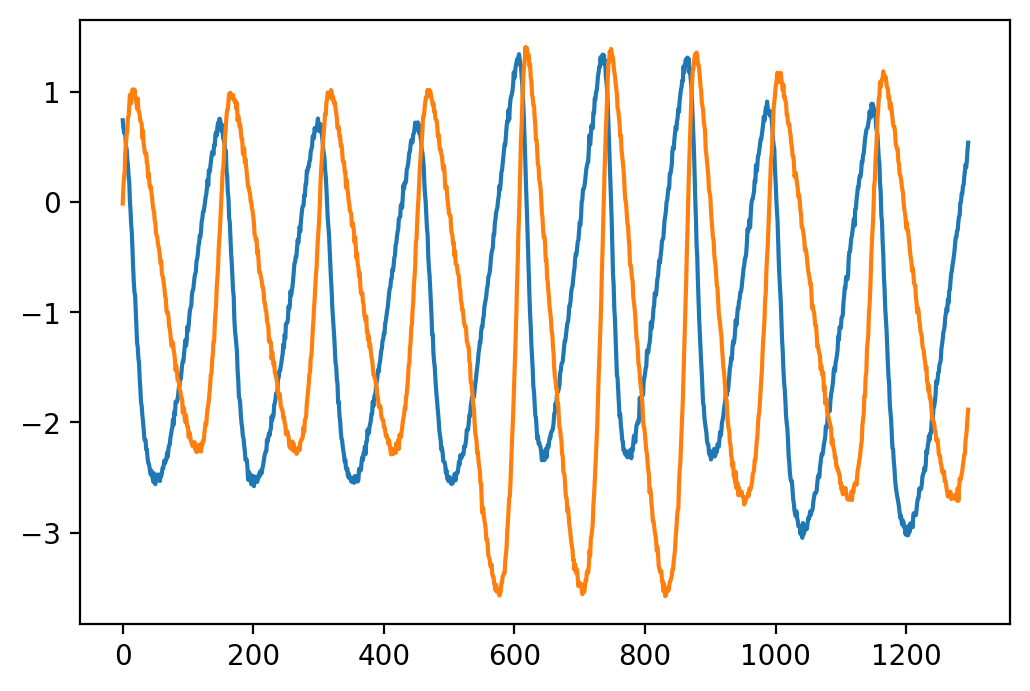

In [3]:
plt.plot(yobs_np[:, 0])
plt.plot(yobs_np[:, 1])

In [2]:
import numpy as np
import torch
import scipy
import argparse
import sys
import matplotlib.pyplot as plt
import matplotlib
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
from multiprocessing import Pool

%matplotlib inline
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 200 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
torch.set_num_threads(1)

def fOde(theta, x):
    """
    description of ODE
    theta: list[4]
    return: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = theta[0] - theta[1] * np.exp(fox)
    Fdt = theta[2] * np.exp(rabbit) - theta[3]
    return np.stack([Rdt, Fdt], axis=1)

def fOdeDx(theta, x):
    """
    returns ODE derivation of x given theta
    theta: list[4]
    x: array(n, 2)
    return: array(n, 2, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    resultDx = np.zeros(shape=[np.shape(x)[0], 2, 2])
    # [:, i, j]: jth equation derivative of the ith state
    # (0) / dR
    resultDx[:, 0, 0] = 0
    # (0) / dF
    resultDx[:, 1, 0] =  -theta[1] * np.exp(fox)
    # (1) / dR
    resultDx[:, 0, 1] = theta[2] * np.exp(rabbit)
    # (1) / dF
    resultDx[:, 1, 1] = 0
    return resultDx

def fOdeDtheta(theta, x):
    """
    returns ODE derivation of theta given x
    theta: list[4]
    x: array(n, 2)
    return: array(n, 4, 2)
    """
    resultDtheta = np.zeros(shape=[np.shape(x)[0], 4, 2])
    # [:, i, j]: jth equation derivative of the ith theta
    rabbit = x[:, 0]
    fox = x[:, 1]
    # (0) / 0
    resultDtheta[:, 0, 0] = 1.
    # (0) / 1
    resultDtheta[:, 1, 0] = -np.exp(fox)
    # (1) / 2
    resultDtheta[:, 2, 1] = np.exp(rabbit)
    # (1) / 3
    resultDtheta[:, 3, 1] = -1.
    return resultDtheta

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

discretization = 1
obs_per_day = 12 
theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, np.inf, np.inf, np.inf])
param_names = ['alpha', 'beta', 'delta', 'gamma']
is_time_varying=[False, False, False, True] 
use_trajectory='inferred'
learning_rate=np.array([1e-4, 1e-3, 1e-5])
n_iter = [15001, 200000, 15000, 200000]
    
yobs = yobs_np[:12 * days]
start_time = time.time()
nobs, p_dim = yobs.shape[0], yobs.shape[1]
n_points = nobs * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
# First stage: use MAGI package to optimize theta as constant
result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=n_iter[0],
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(n_iter[0] * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
    each_pycov = dict(
        Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
        Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
        mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
    )
    CovAllDimensionsPyList.append(each_pycov)
    
inferred_theta

array([0.59775419, 0.75258479, 0.99355992, 0.59767682])

In [58]:
# Construct theta series
def construct(val, occurence_times, history_value):
    ls = [history_value[int(np.sum(occurence_times)):]]
    for idx in range(occurence_times[0]):
        ls.append(torch.tensor([history_value[-1].item()]))
    for idx in range(occurence_times[1]):
        ls.append(val[0])
    return torch.cat(ls, axis=0).reshape(-1, 1)


# Construct theta series
def calibration_construct(vals, occurence_times_2):
    ls = []
    for idx in range(len(occurence_times_2)):
        for repeat_num in range(occurence_times_2[idx]):
            ls.append(vals[idx])
    return torch.cat(ls, axis=0).reshape(-1, 1)


def update_indicator(history_indicator, idx, batch_size=12):
    cur_val = history_indicator[-1]
    if idx == -1:
        return np.concatenate([history_indicator[batch_size:], cur_val * np.ones(batch_size)])
    return np.concatenate([history_indicator[batch_size:], cur_val * np.ones(idx), (1-cur_val) * np.ones(batch_size-idx)]) 
    


def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = constant_param_ls[0] - constant_param_ls[1] * torch.exp(fox)
    Fdt = constant_param_ls[2] * torch.exp(rabbit) - theta[:, 0]
    return torch.stack([Rdt, Fdt], axis=1)


def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res), res.detach().numpy()


def new_likelihood(xlatent, vals, occurence_times, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, history_value):
    new_theta = construct(vals, occurence_times, history_value)
    return pointwisethetasigmallikTorch(xlatent, new_theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature)

result_ls = []
cpd_ls = []
latentx_ls = []
psi_ls = []
history_value = torch.tensor(inferred_theta[3] * np.ones(days * obs_per_day))
history_indicator = np.zeros(days * obs_per_day)

sigma_torch = torch.tensor(inferred_sigma, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == False:
        param_name = param_names[thetaEachDim]
        globals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double) # , requires_grad=True
        time_constant_param_ls.append(eval(param_name))
# for each new batch
for EachBatch in range(n_batch):
    print('Batch ' + str(EachBatch))
    previous_psi = []
    for each in time_constant_param_ls:
        previous_psi.append(each.detach().clone())
    print(previous_psi)
#     theta_lowerbound=np.array([0., 0., 0., 0.])
#     theta_upperbound=np.array([np.inf, np.inf, np.inf, np.inf])
#     param_names = ['alpha', 'beta', 'delta', 'gamma']
#     is_time_varying=[False, False, False, True] 
#     use_trajectory='inferred'
#     days = 5
    
#     start_time = time.time()
#     nobs, p_dim = yobs.shape[0], yobs.shape[1]
#     n_points = nobs * discretization
#     theta_dim = theta_lowerbound.shape[0]
#     d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
#     for i in range(n_points):
#         for j in range(n_points):
#             if i > j:
#                 d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
#             else:
#                 d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
#     Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
#                              thetaLowerBound=theta_lowerbound,
#                              thetaUpperBound=theta_upperbound)
#     tvecObs = np.arange(0, days, 1. / obs_per_day)
#     tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
#     yFull = np.ndarray([n_points, p_dim])
#     yFull.fill(np.nan)
#     yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
#     xInitExogenous = np.zeros_like(yFull)
#     # interpolate: find the ydata of tvecFull given observations
#     for i in range(p_dim):
#         xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
#     # First stage: use MAGI package to optimize theta as constant
#     result = solve_magi(
#         yFull,
#         Ode_system,
#         tvecFull,
#         sigmaExogenous=np.array([]),
#         phiExogenous=np.array([[]]),
#         xInitExogenous=xInitExogenous,
#         thetaInitExogenous=np.array([]),
#         muExogenous=np.array([[]]),
#         dotmuExogenous=np.array([[]]),
#         priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
#         priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
#         priorTemperatureObs=1.0,
#         kernel="generalMatern",
#         nstepsHmc=100,
#         burninRatioHmc=0.5,
#         niterHmc=MAGI_iter,
#         stepSizeFactorHmc=0.01,
#         nEpoch=1,
#         bandSize=40,
#         useFrequencyBasedPrior=True,
#         useBand=False,
#         useMean=False,
#         useScalerSigma=False,
#         useFixedSigma=False,
#         verbose=True)
#     samplesCpp = result['samplesCpp']
#     llikId = 0
#     xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
#     # dimension of theta
#     thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
#     sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
#     burnin = int(MAGI_iter * 0.5)
#     xsampled = samplesCpp[xId, (burnin + 1):]
#     xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
#     CovAllDimensionsPyList = []
#     thetaSampled = samplesCpp[thetaId, (burnin + 1):]
#     inferred_theta_2 = np.mean(thetaSampled, axis=-1)
#     print(inferred_theta_2)
#     sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
#     inferred_sigma = np.mean(sigmaSampled, axis=-1)
#     inferred_trajectory = np.mean(xsampled, axis=-1)
#     for each_gpcov in result['result_solved'].covAllDimensions:
#         each_pycov = dict(
#             Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
#             Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
#             mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
#         )
#         CovAllDimensionsPyList.append(each_pycov)    
    yobs = yobs_np[int((EachBatch+1) * batch_size):int((EachBatch+1) * batch_size + days * obs_per_day)]
    
    ydata = torch.from_numpy(yobs).double()
    priorTemperature = torch.tensor([discretization, discretization, 1.0])
    cur_loss = np.inf
    occurence_times = np.array([batch_size, 0])
    lik_ls = np.zeros(batch_size+1)
    val_ls = np.zeros(batch_size+1)
    truncate_pointwise_xlatent_torch_tmp = torch.tensor(ydata, requires_grad=True, dtype=torch.double)
    # try every time stamp
    for EachIter in range(batch_size+1):
        print(EachIter)
        vals_tmp = torch.tensor([[history_value[-1].item()]], requires_grad=True)
        sigma_torch_tmp = sigma_torch.detach().clone()
        pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, vals_tmp]+ time_constant_param_ls, lr=1e-4)  #  , weight_decay = 1.0
        pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
        cur_loss_tmp = np.inf
        for epoch in range(100000):
            pointwise_optimizer.zero_grad()
            # compute loss function

            llik, res = new_likelihood(truncate_pointwise_xlatent_torch_tmp, vals_tmp, occurence_times, time_constant_param_ls, sigma_torch_tmp,
                                        ydata, CovAllDimensionsPyList, fOdeTorch, #    
                                        priorTemperature, history_value)
            new_loss = -llik
            if epoch % 1000 == 0:
                print(epoch, new_loss.item())
            if epoch % 200 == 0:
                diff = new_loss.item() - cur_loss_tmp
                if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                    break
                cur_loss_tmp = new_loss.item()
            new_loss.backward()
            pointwise_optimizer.step()
            pointwise_lr_scheduler.step()
        lik_ls[EachIter] = llik.item()
        val_ls[EachIter] = vals_tmp.detach().numpy()
        occurence_times[0] -= 1
        occurence_times[1] += 1
    print(lik_ls)
    print('time_constant_param_ls', time_constant_param_ls)
    # update history of gamma
    # change point not detected
    if max(lik_ls) - lik_ls[0] <= 20.:
        # update history
        print('No change point!')
        history_indicator = update_indicator(history_indicator, -1)
        splits = np.split(history_indicator,np.where(np.diff(history_indicator))[0]+1)
        occurence_times_2 = np.array([len(i) for i in splits])
        new_vals = torch.tensor(history_value[-1].item() * np.ones(len(occurence_times_2)).reshape(-1,1), requires_grad=True)
        if len(occurence_times_2) == 1:
            for each in time_constant_param_ls:
                each.requires_grad = True
                print('Turn on!')
        pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, new_vals]+ time_constant_param_ls, lr=1e-4)  #  , weight_decay = 1.0
        pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
        cur_loss_tmp = np.inf
        for epoch in range(100000):
            pointwise_optimizer.zero_grad()
            # compute loss function
            new_theta = calibration_construct(new_vals, occurence_times_2)
            llik, res = pointwisethetasigmallikTorch(truncate_pointwise_xlatent_torch_tmp, new_theta, time_constant_param_ls, sigma_torch, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature)
            new_loss = -llik
            if epoch % 1000 == 0:
                print('calibration H0: ', epoch, new_loss.item())
            if epoch % 200 == 0:
                diff = new_loss.item() - cur_loss_tmp
                if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                    break
                cur_loss_tmp = new_loss.item()
            new_loss.backward()
            pointwise_optimizer.step()
            pointwise_lr_scheduler.step()
                
        history_value = new_theta.detach()[:, 0]
        print(history_value)
        result_ls.append(history_value)
        latentx_ls.append(truncate_pointwise_xlatent_torch_tmp)
        cpd_ls.append(0)
        psi_to_save = []
        for EachPsi in time_constant_param_ls:
            psi_to_save.append(EachPsi.detach().clone())
        psi_ls.append(psi_to_save)
    # change point detected
    else:     
        idx = batch_size - np.argmax(lik_ls)
        print('Change point: ', days * obs_per_day + idx + EachBatch * batch_size)
        history_indicator = update_indicator(history_indicator, idx)
        splits = np.split(history_indicator,np.where(np.diff(history_indicator))[0]+1)
        occurence_times_2 = np.array([len(i) for i in splits])
        new_vals = torch.tensor(history_value[-1].item() * np.ones(len(occurence_times_2)).reshape(-1,1), requires_grad=True)
        time_constant_param_ls = previous_psi.copy()
        
        
        # merge change points
        if (len(occurence_times_2) >= 2 and occurence_times_2[-2] <= 20) or np.abs(new_vals[-1].item() - new_vals[-2].item()) <= 0.2:
            new_vals_alternative = torch.tensor(history_value[-1].item() * np.ones(len(occurence_times_2)-1).reshape(-1,1), requires_grad=True)
            occurence_times_alternative = occurence_times_2.copy()[:-1]
            occurence_times_alternative[-1] += occurence_times_2[-1]
            time_constant_param_ls = previous_psi.copy()
            print('Turn off!')
            print(new_vals_alternative)
            print(occurence_times_alternative)
            pointwise_optimizer_alternative = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, new_vals_alternative], lr=1e-4)  #  , weight_decay = 1.0
            pointwise_lr_scheduler_alternative = torch.optim.lr_scheduler.StepLR(pointwise_optimizer_alternative, step_size=5000, gamma=0.5)
            cur_loss_tmp_alternative = np.inf
            for epoch in range(100000):
                pointwise_optimizer_alternative.zero_grad()
                # compute loss function
                new_theta_alternative = calibration_construct(new_vals_alternative, occurence_times_alternative)
                llik_alternative, res_alternative = pointwisethetasigmallikTorch(truncate_pointwise_xlatent_torch_tmp, new_theta_alternative, time_constant_param_ls, sigma_torch, ydata, CovAllDimensionsPyList, fOdeTorch,
                                     priorTemperature)
                new_loss_alternative = -llik_alternative
                if epoch % 1000 == 0:
                    print('calibration H1: ', epoch, new_loss_alternative.item())
                if epoch % 200 == 0:
                    diff = new_loss_alternative.item() - cur_loss_tmp_alternative
                    if torch.isnan(new_loss_alternative) == False and diff > -0.01 and diff < 0.01:
                        break
                    cur_loss_tmp_alternative = new_loss_alternative.item()
                new_loss_alternative.backward()
                pointwise_optimizer_alternative.step()
                pointwise_lr_scheduler_alternative.step()
                
            if max(lik_ls) - llik_alternative <= 20:
                print('Merge!')
                new_theta = new_theta_alternative.clone()
                idx = len(history_indicator) - 1
                for i in range(occurence_times_2[-1]):
                    history_indicator[idx] = 1 - history_indicator[idx]
                    idx -= 1
                print(history_indicator)
                occurence_times_2 = occurence_times_alternative.copy()
                new_vals = new_vals_alternative.detach().clone()
                print(new_vals)
                new_vals.requires_grad = True
            else:
                print('Merge fails!')

        pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, new_vals], lr=1e-4)  #  , weight_decay = 1.0
        pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
        cur_loss_tmp = np.inf        
        for epoch in range(100000):
            pointwise_optimizer.zero_grad()
            # compute loss function
            new_theta = calibration_construct(new_vals, occurence_times_2)
            llik, res = pointwisethetasigmallikTorch(truncate_pointwise_xlatent_torch_tmp, new_theta, time_constant_param_ls, sigma_torch, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature)
            new_loss = -llik
            if epoch % 1000 == 0:
                print('calibration H1: ', epoch, new_loss.item())
            if epoch % 200 == 0:
                diff = new_loss.item() - cur_loss_tmp
                if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                    break
                cur_loss_tmp = new_loss.item()
            new_loss.backward()
            pointwise_optimizer.step()
            pointwise_lr_scheduler.step()

        
                
        history_value = new_theta.detach()[:, 0]
        print(history_value)
        cpd_ls.append(1)
        result_ls.append(history_value)
        latentx_ls.append(truncate_pointwise_xlatent_torch_tmp)
        psi_to_save = []
        for EachPsi in time_constant_param_ls:
            psi_to_save.append(EachPsi.detach().clone())
        psi_ls.append(psi_to_save)

Batch 0
[tensor([0.5978], dtype=torch.float64), tensor([0.7526], dtype=torch.float64), tensor([0.9936], dtype=torch.float64)]
0
0 286525.49856416596


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1000 315.63901591495073
2000 -457.4947212707203
3000 -541.0463393413381
4000 -560.0847890906039
5000 -565.573704766372
6000 -566.5309758416317
7000 -566.9334782898252
8000 -567.1255520437742
9000 -567.3276119839404
10000 -567.5602761668453
11000 -567.6883242200325
12000 -567.8211984721214
13000 -567.9257895965668
1
0 -567.9729603663302
2
0 -567.9929641897911
3
0 -567.9171455537715
4
0 -566.8739548030485
5
0 -565.4068347653665
1000 -568.0748063171025
6
0 -561.4407688459128
1000 -568.0692232219997
7
0 -563.4390327255869
1000 -568.0921872227752
8
0 -558.3364098350913
1000 -568.1047582867473
9
0 -557.1065931102846
1000 -568.1122016899303
10
0 -556.7611019040933
1000 -568.117016529668
11
0 -556.3476734294879
1000 -568.0955623816707
12
0 -561.9855510605653
[567.97296037 567.99298501 567.99806237 568.01248785 568.04029353
 568.07480632 568.06922322 568.09809164 568.12477458 568.13077161
 568.13483434 568.09556238 568.05748583]
time_constant_param_ls [tensor([0.5962], dtype=torch.float64, requ

In [48]:
# batch 36, 37, 70

[tensor([0.5900], dtype=torch.float64),
 tensor([0.7397], dtype=torch.float64),
 tensor([1.0127], dtype=torch.float64)]

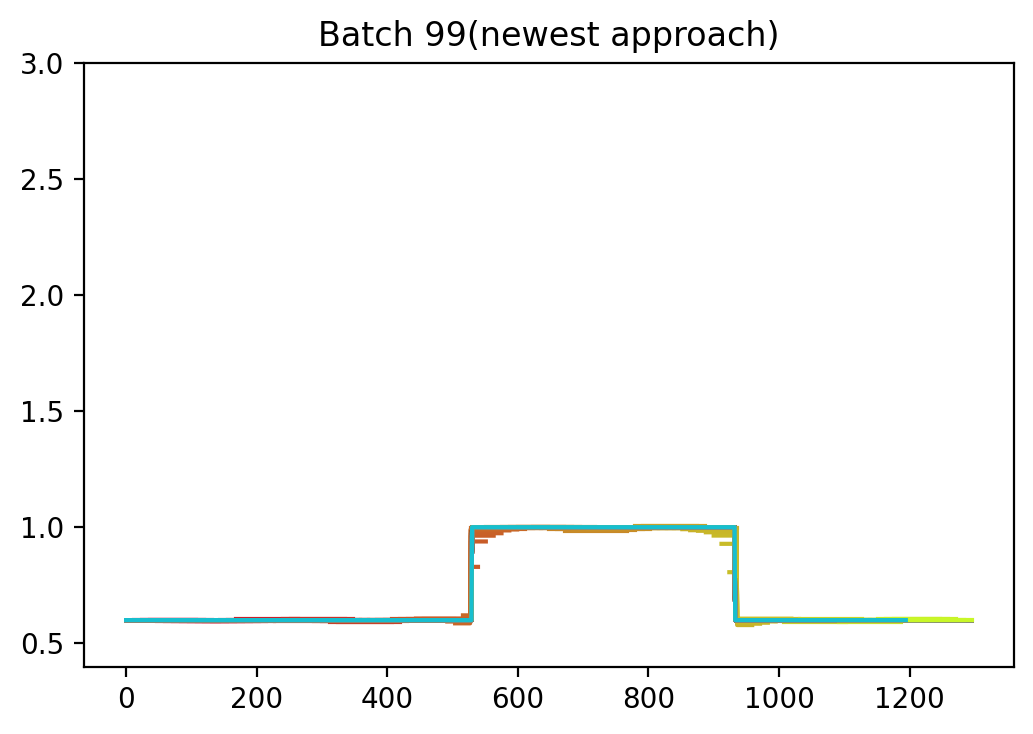

In [61]:
from matplotlib.pyplot import cm
def gen_colors(N):
    values = [int(i*250/N) for i in range(N)]
    # print(values)
    colors=["#%02x%02x%02x"%(200,int(g),40)for g in values] # 250 250 250 ,g值越小越靠近0红色
    return colors

colors = gen_colors(100)
colors

for i in range(n_batch):
    plt.plot(gamma[::1000], label='truth')
    plt.plot(np.arange(12 * i+12, 12 * i + 108, 1), result_ls[i].numpy(), c=colors[i], label=r' $\gamma$ (batch '+str(i) + ')')
    
    plt.title('Batch ' + str(i) + '(newest approach)')
    plt.ylim(0.4, 3.0)
#     plt.plot(np.arange(80, 1280, 12), a, label=r'$\delta$')
#     plt.legend()
#     plt.savefig('plots/100-param-'+ str(i) + '.png')
#     plt.clf()

In [46]:
a = np.array([1,2,3])
b = a
b[-1] += 10
a

array([ 1,  2, 13])

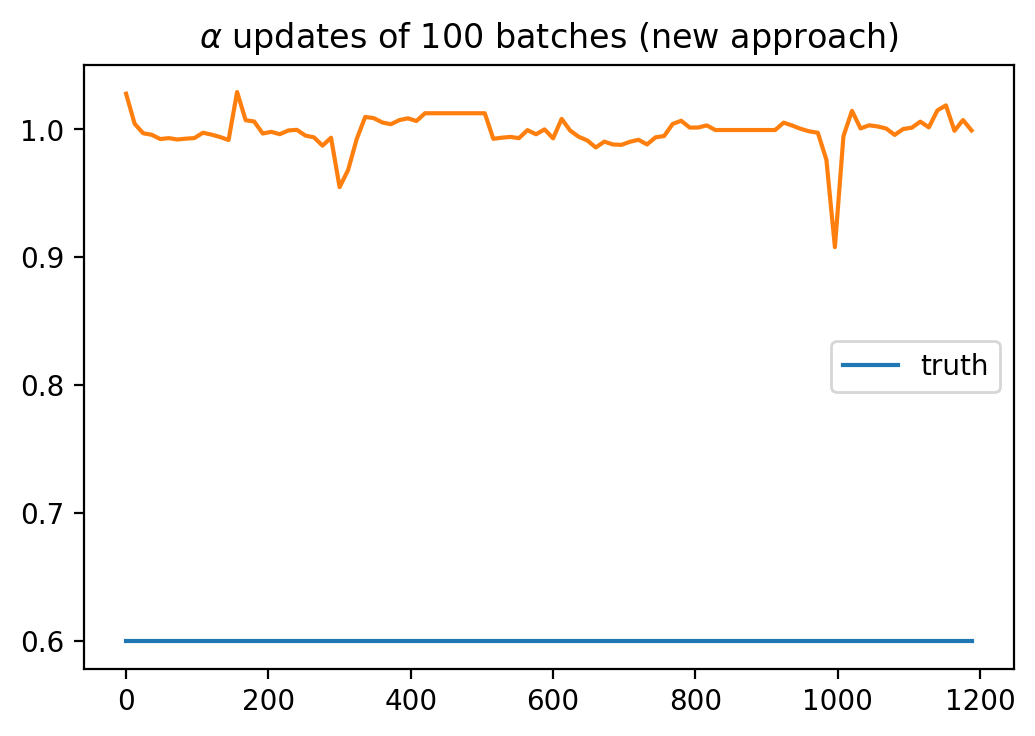

In [60]:
a = np.zeros(100)
plt.plot(np.arange(0, 1200, 12),  0.6 * np.ones(100), label='truth')
for i in range(len(psi_ls)):
    a[i] = psi_ls[i][2].numpy()
    
plt.plot(np.arange(0, 1200, 12), a)
# plt.plot(gamma[::1000], label=r'$\gamma$')
# plt.plot(yobs_np)
plt.title(r'$\alpha$ updates of 100 batches (new approach)')
plt.legend()

In [9]:
a

array([1.02794985, 1.00443064, 0.99701608, 0.99583561, 0.99250525,
       0.99320304, 0.99214898, 0.99280096, 0.99326326, 0.9974211 ,
       0.99598071, 0.99409792, 0.99175324, 1.02926785, 1.00721531,
       1.00620567, 0.9968153 , 0.99814547, 0.99628908, 0.99920762,
       0.99968933, 0.99519784, 0.99383391, 0.98736069, 0.99351599,
       0.954896  , 0.96836246, 0.99240244, 1.00980395, 1.00883901,
       1.00547731, 1.00405763, 1.00730733, 1.0086918 , 1.00660061,
       1.01266805, 1.00593678, 1.00593678, 1.00593678, 1.00593678,
       1.00593678, 1.00593678, 1.00593678, 1.00593678, 0.99380386,
       0.99434598, 0.99321516, 0.99948322, 0.99633973, 1.00016471,
       0.99342391, 1.00836396, 0.9991217 , 0.99427615, 0.9914458 ,
       0.98588919, 0.99048451, 0.98826219, 0.98796781, 0.99033709,
       0.99176631, 0.98813821, 0.99389727, 0.99477623, 1.00428395,
       1.00678893, 1.0014511 , 1.0014669 , 1.00315054, 0.99944759,
       1.01121646, 1.01121646, 1.01121646, 1.01121646, 1.01121

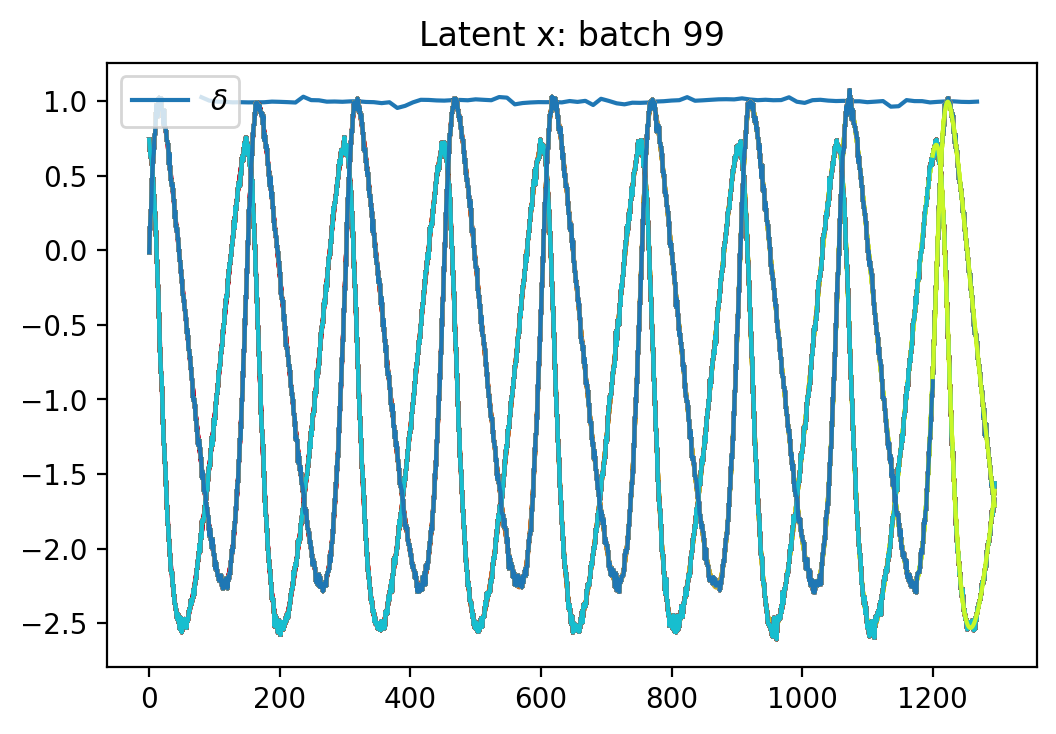

In [69]:
latentx_ls

from matplotlib.pyplot import cm
def gen_colors(N):
    values = [int(i*250/N) for i in range(N)]
    # print(values)
    colors=["#%02x%02x%02x"%(200,int(g),40)for g in values] # 250 250 250 ,g值越小越靠近0红色
    return colors

colors = gen_colors(100)
colors
plt.plot(np.arange(80, 1280, 12), a, label=r'$\delta$')
plt.legend()
for i in range(n_batch):
    plt.plot(yobs_np)
    plt.plot(np.arange(12 * i+12, 12 * i + 108, 1), latentx_ls[i].detach().numpy(), c=colors[i])
    plt.title('Latent x: batch ' + str(i))
    
#     plt.savefig('plots/xlatent-2-'+ str(i) + '.png')
#     plt.clf()

# Generate data, with multiple change points

In [4]:
cp_series

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [7]:
history

ls = [history[:-12]]
for idx in range(occurence_times[0]):
    ls.append(torch.tensor([history[-1].item()]))
for idx in range(occurence_times[1]):
    ls.append(vals_tmp[0])
torch.cat(ls, axis=0).reshape(-1, history.shape[0])

RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [24]:
inferred_trajectory

array([[-2.46522603, -2.44483753, -2.42344485, -2.40100762, -2.37763101,
        -2.35331481, -2.32809588, -2.30204688, -2.27514336, -2.24748899,
        -2.21907003, -2.18991343, -2.16011297, -2.12957296, -2.09836475,
        -2.06650615, -2.0340883 , -2.00104067, -1.967401  , -1.93332706,
        -1.89862436, -1.86346156, -1.82779648, -1.7916436 , -1.75507323,
        -1.7180559 , -1.68060777, -1.64277645, -1.60456416, -1.56598091,
        -1.52704181, -1.48780899, -1.4481823 , -1.40824423, -1.36801822,
        -1.32746601, -1.28664424, -1.24557636, -1.20419972, -1.16259879,
        -1.12074941, -1.07867248, -1.03634503, -0.99382427, -0.95110844,
        -0.90818121, -0.86502695, -0.8216822 , -0.77816496, -0.73446655,
        -0.69057594, -0.64655467, -0.60237395, -0.55803404, -0.51355499,
        -0.46893952, -0.42418072, -0.37929857, -0.33438825, -0.28924474],
       [-0.66655395, -0.70423093, -0.74189977, -0.7795485 , -0.817193  ,
        -0.85485203, -0.89245662, -0.93009169, -0.

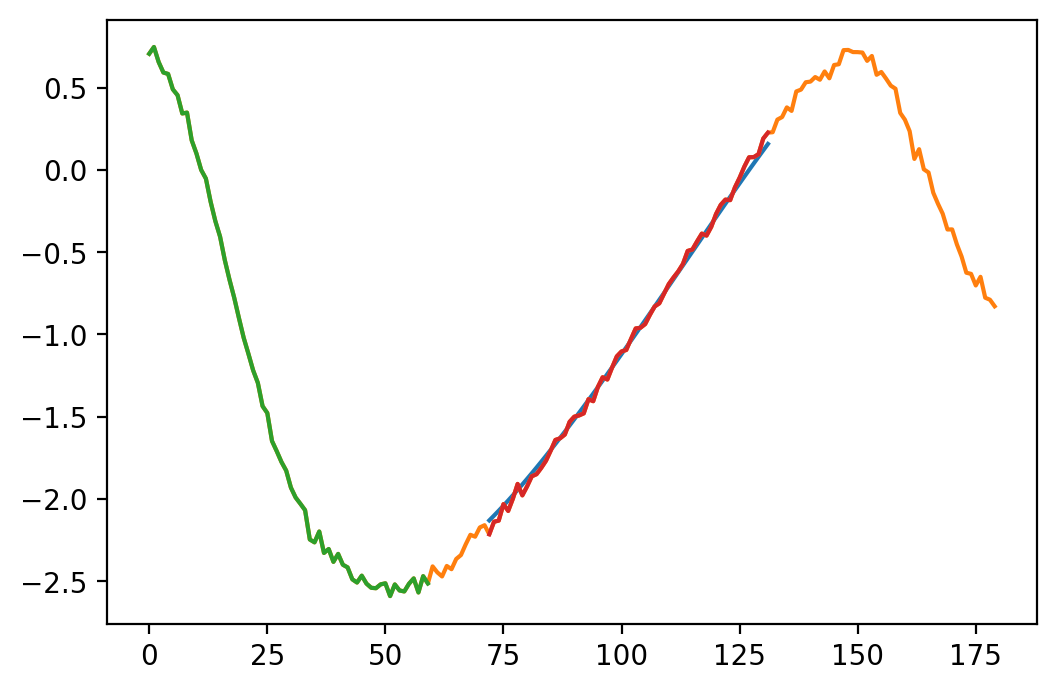

In [12]:
plt.plot(np.arange(72, 132, 1), truncate_pointwise_xlatent_torch_tmp.detach().numpy()[:, 0])

plt.plot(yobs_np[:, 0])
plt.plot(yFull[:, 0])
plt.plot(np.arange(72, 132, 1), yobs[:, 0])
# plt.plot(truncate_pointwise_xlatent_torch_tmp.detach().numpy()[:, 1])
# plt.plot(yobs[:, 1])

In [4]:
n_batch = 50
batch_size = 12
np.random.seed(5)
cp_val = np.random.binomial(1, 0.1, n_batch)
cp_series = np.zeros(0)
for i in range(n_batch):
    if cp_val[i] == 0:
        cp_series = np.concatenate((cp_series, np.zeros(batch_size)), axis=None)
    else:
        np.random.seed(i)
        new_series = np.random.multinomial(1, [1/batch_size] * batch_size)
        cp_series = np.concatenate((cp_series, new_series), axis=None)
        
for i in range(50):
    print(cp_series[i * 12:i * 12 + 12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0.

# Partial code

In [7]:
ydata = torch.from_numpy(yFull).double()

history = torch.tensor(0.6 * np.ones(48))
TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1
pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)

tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == False:
        param_name = param_names[thetaEachDim]
        globals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double) # 
        time_constant_param_ls.append(eval(param_name))

priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
cur_loss = np.inf
occurence_times = np.array([12, 0])
lik_ls = np.zeros(12)
val_ls = np.zeros(12)
# try every time stamp
for EachIter in range(12):
    print(EachIter)
#         if EachIter in lik_ls.keys():
#             continue
    vals_tmp = torch.tensor(np.array([[inferred_theta[3]]]), requires_grad=True)
    truncate_pointwise_xlatent_torch_tmp = pointwise_xlatent_torch.detach().clone()
    truncate_pointwise_xlatent_torch_tmp.requires_grad = True
    sigma_torch_tmp = sigma_torch.detach().clone()
    pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, vals_tmp] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
    pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
    cur_loss_tmp = np.inf
    for epoch in range(100000):
        pointwise_optimizer.zero_grad()
        # compute loss function

        llik, res = new_likelihood(truncate_pointwise_xlatent_torch_tmp, vals_tmp, occurence_times, time_constant_param_ls, sigma_torch_tmp,
                                    ydata, CovAllDimensionsPyList, fOdeTorch, #    
                                    priorTemperature, history)
        new_loss = -llik
        if epoch % 200 == 0:
            print(epoch, new_loss.item())
            diff = new_loss.item() - cur_loss_tmp
            if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                break
            cur_loss_tmp = new_loss.item()
        new_loss.backward()
        pointwise_optimizer.step()
        pointwise_lr_scheduler.step()
    lik_ls[EachIter] = llik.item()
    val_ls[EachIter] = vals_tmp.detach().numpy()
    occurence_times[0] -= 1
    occurence_times[1] += 1
print(lik_ls)
# update history of gamma
# change point not detected
if max(lik_ls) - lik_ls[0] <= 3.84:
    # update history
    print('No change point!')
    history = construct(torch.tensor([history[-1]]), [12, 0], history)
else:
    idx = np.argmax(lik_ls)
    print('Change point: ', batch_size - idx + EachBatch * batch_size)
    history = construct(torch.tensor([val_ls[idx]]), [12-idx, idx], history)

0
0 6571.999635979358
200 5970.55200686959
400 5447.9569388777245
600 4958.226757846603
800 4500.646888280952
1000 4074.4103195247862
1200 3678.0998940666627
1400 3310.113929378733
1600 2968.8297573176396
1800 2652.669471094792
2000 2360.1282001674135
2200 2089.787467982998
2400 1840.320071505113
2600 1610.4929168960252
2800 1399.1687261674563
3000 1205.2998744698089


KeyboardInterrupt: 

In [5]:
time_constant_param_ls

[tensor([0.5792], dtype=torch.float64, requires_grad=True),
 tensor([0.6806], dtype=torch.float64, requires_grad=True),
 tensor([0.0963], dtype=torch.float64, requires_grad=True)]

In [41]:
torch.cat([torch.tensor([1,2,3]), torch.tensor([1]),torch.tensor([2])], axis=0)

tensor([1, 2, 3, 1, 2])

In [43]:
a = torch.tensor([1,2,3])
torch.tensor([a[-1]])

tensor([3])

[1, 1, 2, 2, 3]